#Reinforcement Learning Project


---


*made by Alessandro Lambertini and Denise Landini*

*mat. 1938390 and 1938388*

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

# global variables to save the tables/models 
dir = 'drive/MyDrive/Colab Notebooks/RL/Saves/'

dir_QCarPole = dir+'Q_CarPole_Tables/'
dir_QTaxi = dir+'Q_Taxi_Tables/'

dir_SarsaCarPole = dir+'Sarsa_CarPole_Tables/'
dir_SarsaTaxi = dir+'Sarsa_Taxi_Tables/'

dir_DQNCarPole = dir+'DQN_CarPole_Tables/'
dir_DQNTaxi = dir+'DQN_Taxi_Tables/'

if not os.path.exists(dir):
  os.makedirs(dir)

if not os.path.exists(dir_QCarPole):
  os.makedirs(dir_QCarPole)
if not os.path.exists(dir_QTaxi):
  os.makedirs(dir_QTaxi)

if not os.path.exists(dir_SarsaCarPole):
  os.makedirs(dir_SarsaCarPole)
if not os.path.exists(dir_SarsaTaxi):
  os.makedirs(dir_SarsaTaxi)

if not os.path.exists(dir_DQNCarPole):
  os.makedirs(dir_DQNCarPole)
if not os.path.exists(dir_DQNTaxi):
  os.makedirs(dir_DQNTaxi)

Mounted at /content/drive


###imports

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null
!apt-get install -y x11-utils > /dev/null
!pip install pyvirtualdisplay > /dev/null
!pip install pyglet > /dev/null

In [2]:
import os
import base64
import time
import imageio
import random

import numpy as np

from pyvirtualdisplay import Display
import IPython
from IPython.display import display, clear_output#, HTML, clear_output

display = Display(visible=0, size=(1000, 600))
display.start()

import gym
from gym import ObservationWrapper
from gym.spaces import Discrete, Tuple

from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from collections import defaultdict, namedtuple
from functools import reduce

import cloudpickle as pickle

import seaborn as sns

In [3]:
# Function to show the video of the execution of the agent in the enviroment
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

##Q CarPole

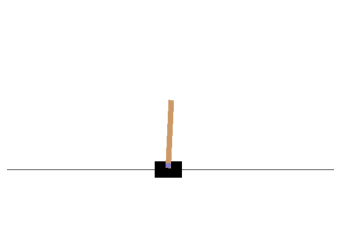

In [ ]:
# Current enviroment
env = gym.make("CartPole-v1")
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'));

###Class

In [ ]:
class CarpoleEnv(ObservationWrapper):
  def __init__(self, env, bins, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, low, high):
    super().__init__(env)

    # Number of bins per feature
    self._bins = bins

    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

    # Discretization of the observation space
    self.observation_space = Discrete(np.prod(self._bins))

    # Object to bin continuous data into intervals
    self._bins_discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    self._bins_discretizer.fit([low, high])

    # Q table and H table
    self._Q = np.zeros(shape=(self.observation_space.n, self.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))

  # Return the index of the table that correspond to this observation
  def fromObsToNum(self, observation):
    return sum([observation[-(i+1)] if i == 0 else reduce(lambda x, y: x*y, self._bins[-i:]) * observation[-(i+1)] for i in reversed(range(len(self._bins))) ])

  # Discretize the observation into the bins
  def discretizer(self, car_position, car_velocity, pole_angle, pole_velocity):
    return tuple(map(int, self._bins_discretizer.transform([[car_position, car_velocity, pole_angle, pole_velocity]])[0] ))

  # Overriding the method observation in order to return the discretized observation
  def observation(self, observation):
    return self.fromObsToNum(self.discretizer(*observation))

  # return the next action to do based on the current observation
  def policy(self, current_observation):
    return np.argmax(self._Q[current_observation])

  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())

  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.action_space.sample()
        
        # Perform action
        next_observation, reward, done, _info = self.step(action)
        argmax_a = np.argmax(self._Q[next_observation])

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * np.max(self._Q[next_observation]) *\
            (1-int(done)) - self._Q[current_observation, action]
        intent_update = np.zeros(self._Q.shape)

        intent_update[current_observation, action] += 1
        expected_intent = intent_update + self._γ * self._H[next_observation, argmax_a] *\
            (1-int(done)) - self._H[current_observation, action]
        
        # update Q and H
        self._Q[current_observation, action] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
            self._α * expected_intent

        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))
        start = time.time()
        
      self.close()
    self.close()

  # Function used to test the trained agent
  def test(self, filename, max = 20):
    # create a new File video
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=30) as video:
      # Restart the enviroment
      current_observation = self.reset()
      # add the current state of the enviroment
      video.append_data(self.render(mode='rgb_array'))
      # init data for the loop
      done = False
      limit = 0
      while not done and limit < max:
        # takes an action based on the policy
        action = self.policy(current_observation)
        # perform action
        next_observation, reward, done, _info = self.step(action)

        # plot data to show the data in H
        print("step: ", limit)
        print("current_observation: ", current_observation)
        print("action: ", action)
        plt.plot(mEnv._H[current_observation, action])
        plt.show()

        current_observation = next_observation
        # add the current state of the enviroment
        video.append_data(self.render(mode='rgb_array'))
        limit += 1
    self.close()
    return embed_mp4(filename)

###Test

learning rate α = 0.1 and discount factor γ = 1

Episode terminates when the length of the episode reaches
200 timestep

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1
throughout the first 500 episodes

In [ ]:
env = gym.make('CartPole-v1') # enviroment

bins=np.array([3, 3, 6, 3]) # bins to subdivide the observation state [car_position, car_velocity, pole_angle, pole_velocity]

α = 0.1 # learning rate
γ = 1.0 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 500 # number of epochs decay

low = np.array([-2.4, -2.5, -np.radians(12), -1]) # Observation space min value
high = np.array([2.4, 2.5, np.radians(12), 1]) # Observation space max value

mEnv = CarpoleEnv(env, bins, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, low, high) # create the enviroment

In [ ]:
mEnv.load(path=dir_QCarPole, name="values") # optional, to load a pretrained agent

Episode 10, reward: 18.600000,  time: 0.047438 s
Episode 20, reward: 18.600000,  time: 0.040206 s
Episode 30, reward: 16.600000,  time: 0.035431 s
Episode 40, reward: 18.600000,  time: 0.040866 s
Episode 50, reward: 26.700000,  time: 0.056323 s
Episode 60, reward: 23.200000,  time: 0.060206 s
Episode 70, reward: 21.700000,  time: 0.052968 s
Episode 80, reward: 17.500000,  time: 0.042235 s
Episode 90, reward: 32.000000,  time: 0.070776 s
Episode 100, reward: 33.600000,  time: 0.077643 s
Episode 110, reward: 34.200000,  time: 0.074970 s
Episode 120, reward: 19.900000,  time: 0.053398 s
Episode 130, reward: 33.200000,  time: 0.072917 s
Episode 140, reward: 28.800000,  time: 0.080444 s
Episode 150, reward: 31.500000,  time: 0.073165 s
Episode 160, reward: 23.500000,  time: 0.060147 s
Episode 170, reward: 39.700000,  time: 0.095853 s
Episode 180, reward: 36.200000,  time: 0.075919 s
Episode 190, reward: 31.400000,  time: 0.068718 s
Episode 200, reward: 47.100000,  time: 0.103600 s
Episode 2

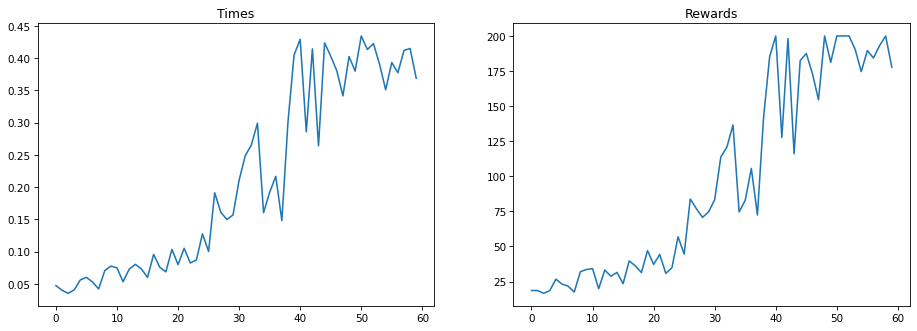

In [ ]:
tot_epochs_train= 600 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=10)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

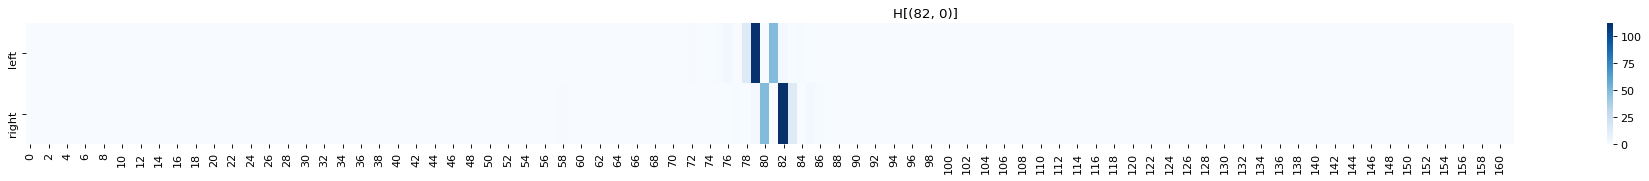

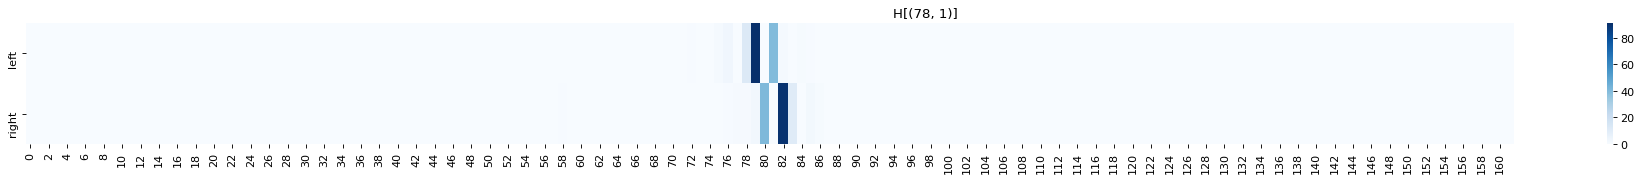

In [ ]:
fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H[(82, 0)]")
sns.heatmap(np.transpose(mEnv._H[(82, 0)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H[(78, 1)]")
sns.heatmap(np.transpose(mEnv._H[(78, 1)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

In [ ]:
mEnv.save(path=dir_QCarPole, name="values") # optional, to the agent trained

step:  0
current_observation:  82
action:  1


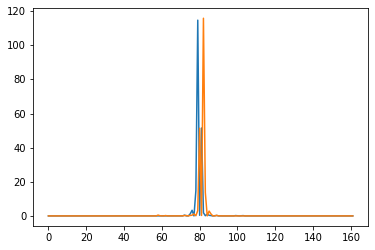

step:  1
current_observation:  82
action:  1


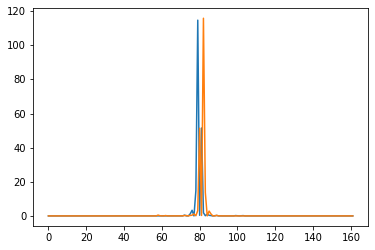

step:  2
current_observation:  81
action:  0


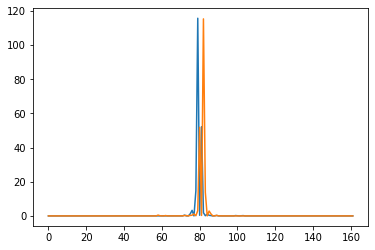

step:  3
current_observation:  82
action:  1


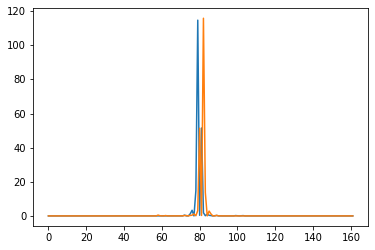

step:  4
current_observation:  81
action:  0


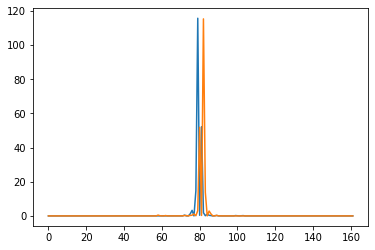

step:  5
current_observation:  79
action:  0


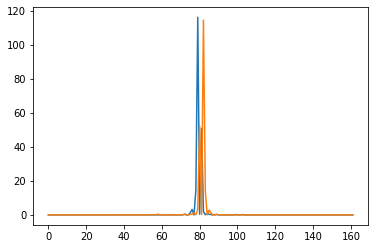

step:  6
current_observation:  79
action:  0


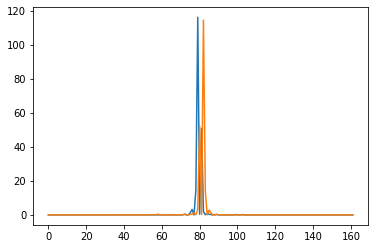

step:  7
current_observation:  79
action:  0


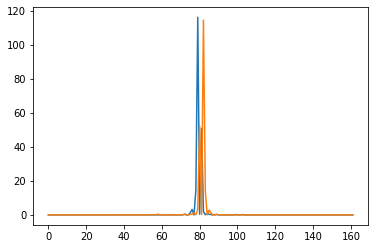

step:  8
current_observation:  80
action:  1


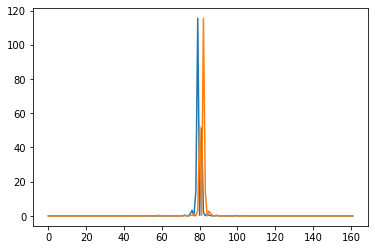

step:  9
current_observation:  82
action:  1


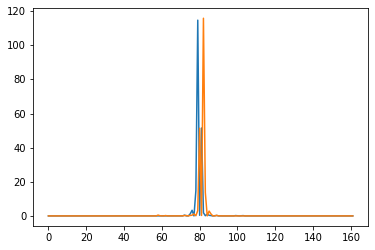

step:  10
current_observation:  82
action:  1


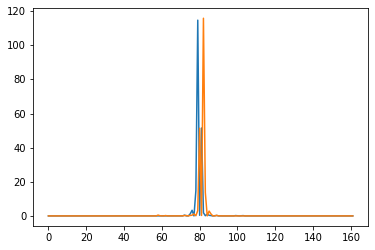

step:  11
current_observation:  82
action:  1


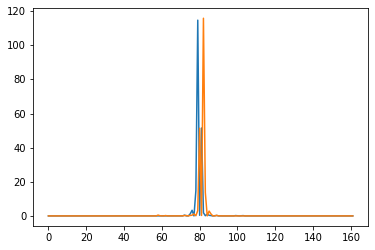

step:  12
current_observation:  81
action:  0


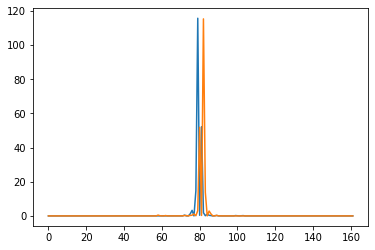

step:  13
current_observation:  79
action:  0


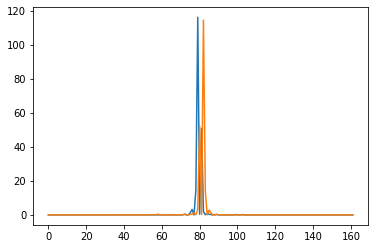

step:  14
current_observation:  79
action:  0


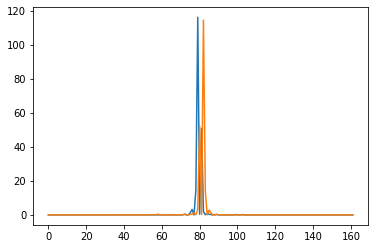

step:  15
current_observation:  79
action:  0


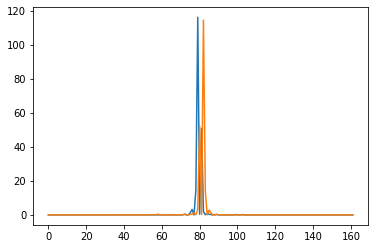

step:  16
current_observation:  80
action:  1


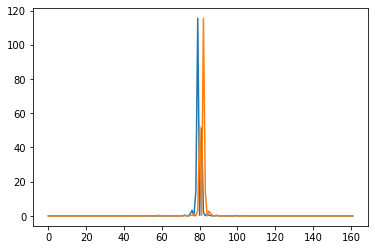

step:  17
current_observation:  82
action:  1


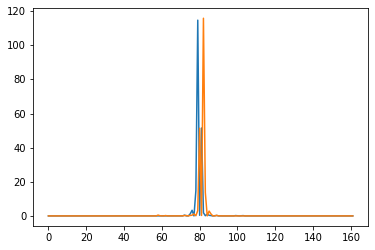

step:  18
current_observation:  82
action:  1


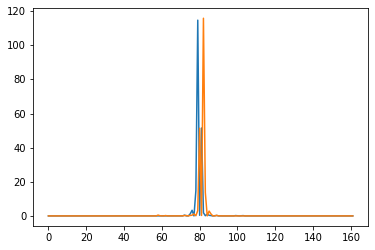

step:  19
current_observation:  82
action:  1


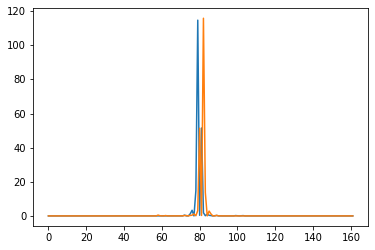

In [ ]:
mEnv.test("QCarPole") # test the agent

##Q Taxi

In [ ]:
# Current enviroment
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



###Class

In [ ]:
class TaxiEnv(ObservationWrapper):
  def __init__(self, env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs):
    super().__init__(env)

    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs

    # Q table and H table
    self._Q = np.zeros((env.observation_space.n, env.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

  # Overriding the method observation
  def observation(self, observation):
    return observation

  # return the next action to do based on the current observation
  def policy(self, state_action):
    return np.argmax(self._Q[state_action])
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())
    
  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.action_space.sample()
        
        # Perform action
        next_observation, reward, done, _info = self.step(action)
        argmax_a = np.argmax(self._Q[next_observation])

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * np.max(self._Q[next_observation]) *\
            (1-int(done)) - self._Q[(current_observation, action)]
        intent_update = np.zeros(self._Q.shape)
        intent_update[current_observation, action] += 1
        expected_intent = intent_update + self._γ * self._H[next_observation, argmax_a] *\
         (1-int(done)) - self._H[current_observation, action]
        
        # update Q and H
        self._Q[current_observation, action] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
         self._α * expected_intent
        
        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))
        start = time.time()
      
      self.close()
    self.close()

  # Function used to test the trained agent
  def test(self, max=50):
    # create a new Buffer
    frames = []
    # Restart the enviroment
    current_observation = self.reset()
    self.render()
    done = False
    limit = 0
    actions = ["down", "up", "right", "left", "pickup passenger", "drop off passenger"]
    sum_reward = 0

    # init data for the loop
    while not done and limit < max:
      # takes an action based on the policy
      action = self.policy(current_observation)
      # perform action
      next_observation, reward, done, _info = self.step(action)

      print("step: ", limit)
      print("current_observation: ", current_observation)
      print("action: ", action)
      plt.plot(mEnv._H[current_observation, action])
      plt.legend(actions)
      plt.show()
      self.render()

      current_observation = next_observation
      limit += 1
      sum_reward += reward

      # add the current state of the enviroment
      frames.append({
        'frame': env.render(mode='ansi'),
        'observation': next_observation,
        'action': actions[action],
        'reward': sum_reward
        })
    self.close()
    def print_frames(frames):
      for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(.5)
    #return print_frames(frames)

###Test

We set the learning rate α = 0.4 and
discount factor γ = 0.9.

An episode terminates when the agent completes the episode or reaches a
threshold of 200 timesteps.

We initially set exploration probability ε = 1 which is linearly decreased
to ε = 0.1 in the first 250 episodes.

In [ ]:
env = gym.make('Taxi-v3') # enviroment

α = 0.4 # learning rate
γ = 0.9 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 250 # number of epochs decay

mEnv = TaxiEnv(env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs)

In [ ]:
mEnv.load(path=dir_QTaxi, name="values") # optional, to load a pretrained agent

Episode 100, reward: -641.860000,  time: 1.039552 s
Episode 200, reward: -270.520000,  time: 0.620404 s
Episode 300, reward: -53.860000,  time: 0.274337 s
Episode 400, reward: -16.240000,  time: 0.146849 s
Episode 500, reward: -3.270000,  time: 0.098827 s
Episode 600, reward: -1.140000,  time: 0.086546 s
Episode 700, reward: -0.940000,  time: 0.077030 s
Episode 800, reward: 2.080000,  time: 0.072394 s
Episode 900, reward: 3.370000,  time: 0.076550 s
Episode 1000, reward: 1.090000,  time: 0.075313 s
Episode 1100, reward: 2.220000,  time: 0.080843 s
Episode 1200, reward: 1.840000,  time: 0.070515 s
Episode 1300, reward: 3.430000,  time: 0.073718 s
Episode 1400, reward: 2.040000,  time: 0.075413 s
Episode 1500, reward: 2.230000,  time: 0.077742 s
Episode 1600, reward: 2.450000,  time: 0.077633 s
Episode 1700, reward: 3.150000,  time: 0.082672 s
Episode 1800, reward: 2.530000,  time: 0.067859 s
Episode 1900, reward: 1.870000,  time: 0.071518 s
Episode 2000, reward: 1.810000,  time: 0.07300

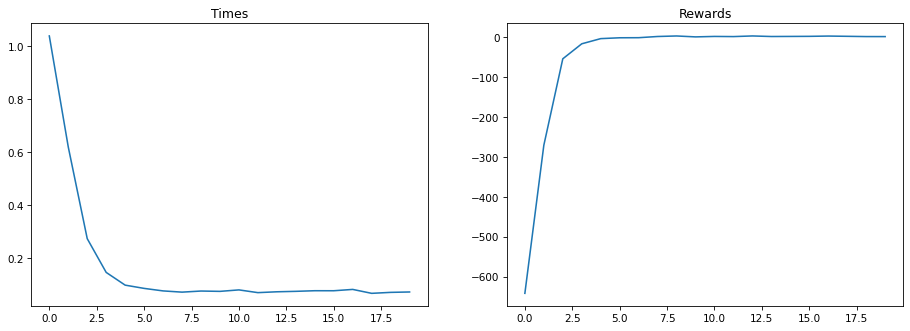

In [ ]:
tot_epochs_train=2000 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=100)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

In [ ]:
mEnv.save(path=dir_QTaxi, name="values") # optional, to the agent trained

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

step:  0
current_observation:  273
action:  0


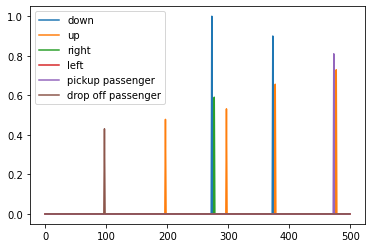

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step:  1
current_observation:  373
action:  0


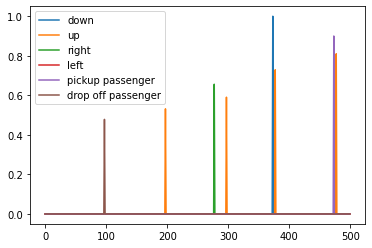

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step:  2
current_observation:  473
action:  4


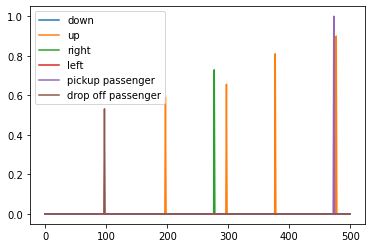

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
step:  3
current_observation:  477
action:  1


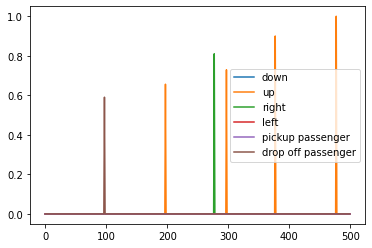

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
step:  4
current_observation:  377
action:  1


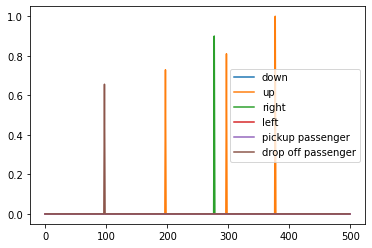

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  5
current_observation:  277
action:  2


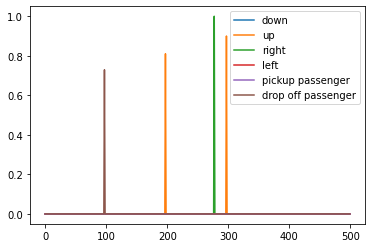

+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (East)
step:  6
current_observation:  297
action:  1


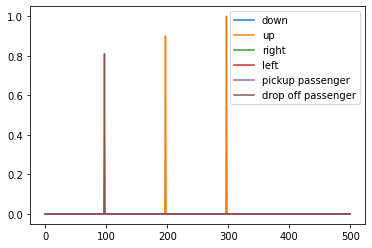

+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  7
current_observation:  197
action:  1


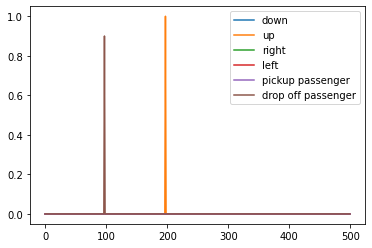

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  8
current_observation:  97
action:  5


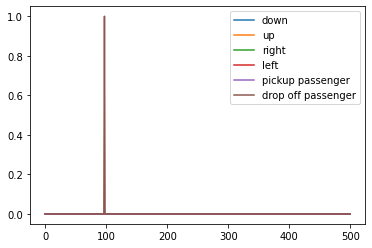

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [ ]:
mEnv.test() # test the agent

##DQN CarPole

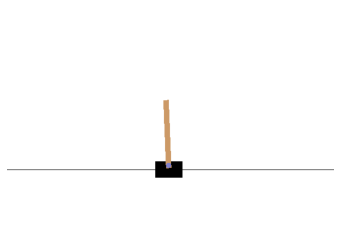

In [4]:
# Current enviroment
env = gym.make("CartPole-v1")
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'));

###Functions

In [5]:
Transition = namedtuple('Transition',
                        ('observation', 'action', 'reward', 'observation_t1', 'done'))

# Pytorch module
class Reshape(nn.Module):
  def __init__(self, *args):
    super(Reshape, self).__init__()
    self.shape = args

  def forward(self, x):
    return x.view(self.shape)

# Pytorch module
class ReplayBuffer():
  def __init__(self, size, device=None, torch=True):
    self._storage = []
    self._maxsize = size
    self._idx = 0
    self.torch = torch
    self.device = device

  def __len__(self):
    return len(self._storage)

  def add(self, obs, action, reward, obs_t1, done):
    data = self._convert_args((obs, action, reward, obs_t1, int(done)))
    data = Transition(*data)
    
    if(self._idx) >= len(self._storage):
      self._storage.append(data)
    else:
      self._storage[self._idx] = data
    self._idx = (self._idx + 1) % self._maxsize

  def _encode_sample(self, idxes, copy=False):
    obses, actions, rewards, obses_t1, dones = [], [], [], [], []
    for i in idxes:
      data = self._storage[i]
      obs, action, reward, obs_t1, done = data
      obses.append(np.array(obs, copy=copy))
      actions.append(np.array(action, copy=copy))
      rewards.append(np.array(reward, copy=copy))
      obses_t1.append(np.array(obs_t1, copy=copy))
      dones.append(np.array(done, copy=copy))

    data = Transition(obses, actions, rewards, obses_t1, dones)
    if self.torch:
      data = Transition(*tuple(map(self.to_torch, data)))
    return data
      
  def sample(self, batch_size, idx=False):
    idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
    if idx:
      return (idx, self._encode_sample(idxes))
    else:
      return self._encode_sample(idxes)

  def to_torch(self, array, copy=False):
    if copy:
      return torch.tensor(array).to(self.device)
    else:
      return torch.as_tensor(array).to(self.device)

  def save(self, path="./", name='values'):
    pickle.dump(self.__dict__, open(path+name+'R.pkl', 'wb'))

  def load(self, path="./", name='values'):
    obj = pickle.load(open(path+name+'R.pkl', 'rb'))
    self.__dict__.update(obj.items())

  def _convert_args(self, data):
    return tuple(map(self.as_list, data))

  def as_list(self, x):
    return x if isinstance(x, (list, np.ndarray)) else np.array([x])

###Policy

In [6]:
class DQN_CarpolePolicy(nn.Module):
  def __init__(self, observation_space, action_space, lr, β1, β2, device):
    nn.Module.__init__(self)

    self.observation_space = observation_space
    self.action_space = action_space

    self._lr = lr # Learning  rate
    self._β1 = β1 # exponential decay
    self._β2 = β2 # exponential decay

    self._device = device

    self.num_states = np.prod(tuple(map(lambda x: x.n, self.observation_space)))

    # DQN and DBN
    self._Q = self._make_Q()
    self._Q_target = self._make_Q()
    self._Q_target.load_state_dict(self._Q.state_dict())
    self._Q_optimizer = optim.Adam(self._Q.parameters(), lr=self._lr)

    self._H = self._make_H()
    self._H_target = self._make_H()
    self._H_target.load_state_dict(self._H.state_dict())
    self._H_optimizer = optim.Adam(self._H.parameters(), lr=self._lr)

  #given an observation return the action to perform
  def predict(self, observation, random_state=False):
    with torch.no_grad():
      Q, H = self.forward(observation)
      H = H.view(-1, self.action_space.n, *tuple(map(lambda x: x.n, self.observation_space)), self.action_space.n)

      if random_state:
        # random action
        action = np.random.choice(2)
        value = Q[0][action]
      else:
        # action based on the policy
        action = Q.argmax(dim=1).reshape(-1).cpu().numpy()[0]
        value = Q.max(dim=1)[0].cpu().numpy()[0]

    return action, value, H

  def forward(self, observation):
    if(observation.ndim == 1):
      observation = np.expand_dims(observation, axis=0)
    observation = torch.as_tensor(observation).float().to(self._device)
    return self._Q(observation), self._H(observation)

  # build DBN
  def _make_H(self):
    modules = [nn.Linear(4, 500), nn.ReLU(), # First layer
                nn.Linear(500, 2000), nn.ReLU(), # Second layer
                nn.Linear(2000, self.num_states*self.action_space.n**2), # Third layer
                Reshape(-1, self.action_space.n, self.num_states, self.action_space.n)]
    return nn.Sequential(*modules).to(self._device)

  # build DQN
  def _make_Q(self):
    modules = [nn.Linear(4, 128), nn.ReLU(), # First layer
                nn.Linear(128, 512), nn.ReLU(), # Second layer
                nn.Linear(512, 2)] # Third layer
    return nn.Sequential(*modules).to(self._device)

  # Saves the DQN and DBN
  def save(self, path="./", name='values'):
    torch.save(self._Q_target.state_dict(), path+name+'Policy_model_Q.pth')
    torch.save(self._Q_optimizer.state_dict(), path+name+'Policy_Q_optimizer.pth')

    torch.save(self._H_target.state_dict(), path+name+'Policy_model_H.pth')
    torch.save(self._H_optimizer.state_dict(), path+name+'Policy_H_optimizer.pth')

  # Load the DQN and DBN
  def load(self, path="./", name='values'):
    self._Q.load_state_dict(torch.load(path+name+'Policy_model_Q.pth'))
    self._Q_target.load_state_dict(torch.load(path+name+'Policy_model_Q.pth'))
    self._Q_optimizer.load_state_dict(torch.load(path+name+'Policy_Q_optimizer.pth'))

    self._H.load_state_dict(torch.load(path+name+'Policy_model_H.pth'))
    self._H_target.load_state_dict(torch.load(path+name+'Policy_model_H.pth'))
    self._H_optimizer.load_state_dict(torch.load(path+name+'Policy_H_optimizer.pth'))

###Class

In [7]:
class DQN_CarpoleEnv(ObservationWrapper):
  def __init__(self, env, α, γ, bins, ε_init_value, ε_final_value, ε_tot_epochs,
                lr, β1, β2, low, high, buffer_size):
    super().__init__(env)

    self._α = α # Learning rate
    self._γ = γ # Discount factor
    self._bins = bins # Number of bins per feature

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs

    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

    self.elapsed_steps = 0
    self.ep_done = 0

    self._lr = lr # Learning rate policy
    self._β1 = β1 # exponential decay
    self._β2 = β2 # exponential decay
    
    self.buffer_size = buffer_size
    self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Object to bin continuous data into intervals
    self._bins_discretizer = KBinsDiscretizer(n_bins=self._bins, encode='ordinal', strategy='uniform')
    self._bins_discretizer.fit([low, high])

    # Discretization of the observation space
    self.observation_space = Tuple([Discrete(x) for x in self._bins])

    self.policy = DQN_CarpolePolicy(self.observation_space, self.action_space,
                                  self._lr, self._β1, self._β2, self._device)

    if self.buffer_size is None:
      self.replay_buffer = None
    else:
      self.replay_buffer = ReplayBuffer(self.buffer_size, device=self._device, torch=True)

  # Discretize the observation into the bins
  def discretizer(self, car_position, car_velocity, pole_angle, pole_velocity):
    return tuple(map(int, self._bins_discretizer.transform([[car_position, car_velocity, pole_angle, pole_velocity]])[0] ))
  
  # Overriding the method observation in order to return the discretized observation
  def observation(self, observation):
    return np.array(self.discretizer(*observation)).astype(np.float32)
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)
  
  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # return the next action to do based on the current observation
  def predict(self, observation, random_state=False):
    return self.policy.predict(np.array(observation), random_state=random_state)

  # Saves the DQN and DBN
  def save(self, path="./", name='values'):
    self.policy.save(path, name)
    if self.replay_buffer is not None:
      self.replay_buffer.save(path, name)

    to_save = self.__dict__.copy()
    for key in ["_device", "replay_buffer"]:
      if key in to_save:
        del to_save[key]
    pickle.dump(to_save, open(path+name+'Data.pkl', 'wb'))

  # Load the DQN and DBN
  def load(self, path="./", name='values'):
    self.policy.load(path, name)
    obj = pickle.load(open(path+name+'Data.pkl', 'rb'))
    for key, item in obj.items():
      self.__dict__[key] = item

  def train(self, tot_epochs_train, max_epoch_step, batch_size=16,
            print_info=False, print_info_episodes=100, ckpt_interval=50):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward  = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment

      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action, value, H = self.predict(current_observation)
        else:
          # action based on the policy
          action, value, H = self.predict(current_observation, random_state=True)

        # Perform action
        next_observation, reward, done, _info = self.step(action)
        self.replay_buffer.add(current_observation, action, reward, next_observation, int(done))
        current_observation = next_observation
        
        if len(self.replay_buffer) < batch_size * 10:
          if len(self.replay_buffer) == batch_size * 10 or done:
            self.reset()
          continue
        self.updateNet(batch_size=batch_size)

        # update data for the loop
        epoch_reward += reward
        step += 1
        self.elapsed_steps += 1
      
      # Print informations for the training
      if epoch % ckpt_interval == 0:
        self.policy._Q_target.load_state_dict(self.policy._Q.state_dict())
        self.policy._H_target.load_state_dict(self.policy._H.state_dict())
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        self.rewards.append(avgReward)
        epoch_reward = 0
        print("Episode %d reward: %f time: %f s" %(epoch, avgReward, self.elapsedTime(start)) )
        start = time.time()
  
  # update DQN and DBN
  def updateNet(self, batch_size):
    replay = self.replay_buffer.sample(batch_size)
    with torch.no_grad():
        target_q = self.policy._Q_target(replay.observation_t1.float())
        target_q, idxes = target_q.max(dim=1)
        target_q = target_q.reshape(-1, 1)
        target_q = replay.reward + self._γ*target_q*(1-replay.done)

    current_q = self.policy._Q(replay.observation.float())
    current_q = current_q.gather(dim=1, index=replay.action)
    current_q = current_q.float()
    target_q = target_q.float()

    loss_q = F.smooth_l1_loss(current_q, target_q)

    if isinstance(self.observation_space, Tuple):
        update = torch.zeros(batch_size, *list(map(lambda x: x.n, self.observation_space)), self.action_space.n).to(self._device)
    else:
        update = torch.zeros(batch_size, self.policy.n_obs_dbn, self.action_space.n).to(self._device)

    for idx, (observation, action) in enumerate(zip(replay.observation, replay.action)):
        encoded_state = observation.long().to(self._device)
        if encoded_state.ndim == 0:
            encoded_state = encoded_state.view(-1)
        _indexing = []
        if isinstance(encoded_state, (list, tuple)) or (isinstance(encoded_state, torch.Tensor) and len(encoded_state) >= 1):
            _indexing.append(idx)
            for s in encoded_state:
                _indexing.append(s)
            _indexing.append(action)
        update[_indexing] += 1

    update = update.view(-1, self.policy.num_states, self.action_space.n)

    with torch.no_grad():
        target_h = self.policy._H_target(replay.observation_t1.float())
        target_h = torch.cat([target_h[idx, x, ...] for idx, x in enumerate(idxes.unsqueeze(-1))])
    target_h = update + self._γ*target_h*(1-replay.done.unsqueeze(-1))

    current_h = self.policy._H(replay.observation.float())
    current_h = torch.cat([current_h[idx, x, ...] for idx, x in enumerate(replay.action)])

    current_h = current_h.float()
    target_h = target_h.float()

    loss_h = F.smooth_l1_loss(current_h, target_h)

    self.policy._Q_optimizer.zero_grad()
    loss_q.backward()
    for param in self.policy._Q.parameters():
        param.grad.data.clamp_(-1, 1)
    self.policy._Q_optimizer.step()

    self.policy._H_optimizer.zero_grad()
    loss_h.backward()
    for param in self.policy._H.parameters():
        param.grad.data.clamp_(-1, 1)
    self.policy._H_optimizer.step()

  # Function used to test the trained agent
  def test(self, filename):
    # create a new File video
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=30) as video:
      # Restart the enviroment
      current_observation = self.reset()
      # add the current state of the enviroment
      video.append_data(self.render(mode='rgb_array'))
      # init data for the loop
      done = False
      while not done:
        # takes an action based on the policy
        action, value, H = self.predict(current_observation)
        # perform action
        next_observation, reward, done, _info = self.step(action)
        current_observation = next_observation
        # add the current state of the enviroment
        video.append_data(self.render(mode='rgb_array'))
    self.close()
    return embed_mp4(filename)

###Test

learning rate α = 0.0001, and discount factor γ = 1

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1 throughout the first 500 episodes

In DQN training, we use Adam optimizer with ε = 1e − 8, exponential decays β1 = 0.9, β2 = 0.999. The learning rate is α = 0.0001.

We clip gradients to be in the range of [−1, 1]. For each learning iteration, we batch 16 experience together for optimisation.

In [13]:
env = gym.make('CartPole-v0') # enviroment

bins=np.array([3, 3, 6, 3]) # bins to subdivide the observation state [car_position, car_velocity, pole_angle, pole_velocity]

α = 0.0001 # learning rate
γ = 1.0 # discount factor

ε_init_value = 1.0 # exploration_probability
ε_final_value = 0.05 # 0.1 # final exploration value
ε_tot_epochs = 500 # number of epochs decay

low = np.array([-2.4, -2.5, -np.radians(12), -1]) # Observation space min value
high = np.array([2.4, 2.5, np.radians(12), 1]) # Observation space max value

lr = 1e-4 # optimize learning rate
β1 = 0.9 # exponential decay
β2 = 0.999 # exponential decay

mEnv = DQN_CarpoleEnv(env, α, γ, bins, ε_init_value, ε_final_value, ε_tot_epochs,
                      lr, β1, β2, low, high, buffer_size=10000) # create the enviroment

In [ ]:
mEnv.load(path=dir_QTaxi, name="values") # optional, to load a pretrained agent

Episode 10 reward: 8.800000 time: 0.982487 s
Episode 20 reward: 20.100000 time: 1.950833 s
Episode 30 reward: 29.300000 time: 2.800617 s
Episode 40 reward: 28.000000 time: 2.668834 s
Episode 50 reward: 26.500000 time: 2.579134 s
Episode 60 reward: 16.800000 time: 1.640909 s
Episode 70 reward: 19.500000 time: 1.891743 s
Episode 80 reward: 25.100000 time: 2.440956 s
Episode 90 reward: 22.600000 time: 2.208597 s
Episode 100 reward: 17.300000 time: 1.700446 s
Episode 110 reward: 16.100000 time: 1.530623 s
Episode 120 reward: 17.400000 time: 1.699638 s
Episode 130 reward: 18.800000 time: 1.813232 s
Episode 140 reward: 30.400000 time: 2.914915 s
Episode 150 reward: 26.400000 time: 2.524766 s
Episode 160 reward: 25.900000 time: 2.506164 s
Episode 170 reward: 20.300000 time: 1.944474 s
Episode 180 reward: 14.100000 time: 1.359336 s
Episode 190 reward: 20.300000 time: 1.943283 s
Episode 200 reward: 28.700000 time: 2.774183 s
Episode 210 reward: 25.900000 time: 2.485613 s
Episode 220 reward: 23.

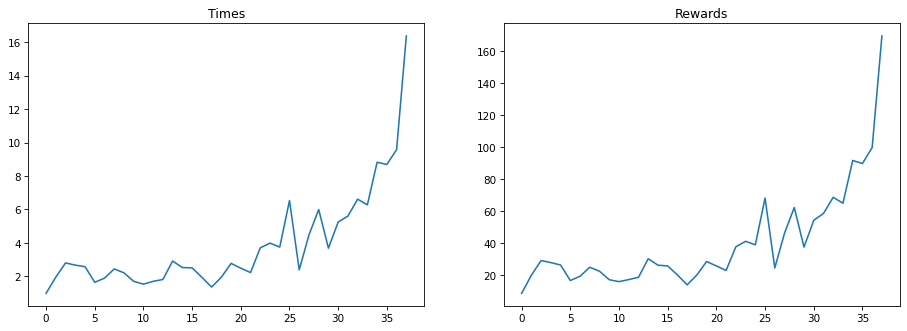

In [14]:
tot_epochs_train=380 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=10)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

In [ ]:
mEnv.save(path=dir_QTaxi, name="values") # optional, to the agent trained

In [16]:
mEnv.test("DQNCarPole") # test the agent

##DQN Taxi

In [19]:
# Current enviroment
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



###Function

In [20]:
#Pytorch module
class HNet(nn.Module):
  def __init__(self, num_observation_space, num_action_space, out_observation):
    super(HNet, self).__init__()
    self.num_observation_space = num_observation_space
    self.num_action_space = num_action_space
    self.out_observation = out_observation

    self.act_stream = nn.Sequential(nn.Linear(self.num_action_space, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 512),
                                    nn.ReLU())
    
    self.intent_stream = nn.Sequential(nn.Linear(self.num_observation_space, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 1024),
                          nn.ReLU())

    self.shared_layers = nn.Sequential(nn.Linear(512+1024, 2048),
                                        nn.ReLU(),
                                        nn.Linear(2048, self.out_observation*self.num_action_space))

  def _onehot(self, arr):
    onehot = torch.cuda.FloatTensor(arr.size()[0], self.num_action_space)
    onehot.zero_()
    onehot.scatter_(1, arr, 1)
    return onehot

  def forward(self, x, y):
    y = self._onehot(y)
    y = self.act_stream(y)
    x = self.intent_stream(x)
    x = torch.cat((x, y), dim=1)
    x = self.shared_layers(x)
    x = x.view(-1, self.out_observation, self.num_action_space)
    return x

#Pytorch module
class ReplayBuffer():
  def __init__(self, size, device=None, torch=True):
    self._storage = []
    self._maxsize = size
    self._idx = 0
    self.torch = torch
    self.device = device

  def __len__(self):
    return len(self._storage)

  def can_sample(self, sample_size):
    return len(self) >= sample_size

  def is_full(self):
    return len(self) == self._maxsize

  def add(self, obs, action, reward, obs_t1, done):
    data = self._convert_args((obs, action, reward, obs_t1, int(done)))
    data = Transition(*data)
    
    if(self._idx) >= len(self._storage):
      self._storage.append(data)
    else:
      self._storage[self._idx] = data
    self._idx = (self._idx + 1) % self._maxsize

  def _encode_sample(self, idxes, copy=False):
    obses, actions, rewards, obses_t1, dones = [], [], [], [], []
    for i in idxes:
      data = self._storage[i]
      obs, action, reward, obs_t1, done = data
      obses.append(np.array(obs, copy=copy))
      actions.append(np.array(action, copy=copy))
      rewards.append(np.array(reward, copy=copy))
      obses_t1.append(np.array(obs_t1, copy=copy))
      dones.append(np.array(done, copy=copy))

    data = Transition(obses, actions, rewards, obses_t1, dones)
    if self.torch:
      data = Transition(*tuple(map(self.to_torch, data)))

    return data
      
  def sample(self, batch_size, idx=False):
    idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
    if idx:
      return (idx, self._encode_sample(idxes))
    else:
      return self._encode_sample(idxes)

  def sample_from_idx(self, idxes):
    return self._encode_sample(idxes)

  def to_torch(self, array, copy=False):
    if copy:
      return torch.tensor(array).to(self.device)
    else:
      return torch.as_tensor(array).to(self.device)

  def save(self, path="./", name='values'):
    pickle.dump(self.__dict__, open(path+name+'R.pkl', 'wb'))

  def load(self, path="./", name='values'):
    obj = pickle.load(open(path+name+'R.pkl', 'rb'))
    self.__dict__.update(obj.items())

  def _convert_args(self, data):
    return tuple(map(self.as_list, data))
  
  def as_list(self, x):
    return x if isinstance(x, (list, np.ndarray)) else np.array([x])

Transition = namedtuple('Transition',
                        ('observation', 'action', 'reward', 'observation_t1', 'done'))

###Policy

In [21]:
class DQN_TaxiPolicy(nn.Module):
  def __init__(self, observation_space, action_space, lr, β1, β2, device):
    nn.Module.__init__(self)

    self.observation_space = observation_space
    self.action_space = action_space

    self._lr = lr # Learning rate
    self._β1 = β1 # Exponential decay
    self._β2 = β2 # Exponential decay
    
    self._device = device

    self.num_states = np.prod(tuple(map(lambda x: x.n, self.observation_space)))

    # DQN and DBN
    self._Q = self._make_Q()
    self._Q_target = self._make_Q()
    self._Q_target.load_state_dict(self._Q.state_dict())
    self._Q_optimizer = optim.Adam(self._Q.parameters(), lr=self._lr)

    self._H = self._make_H()
    self._H_target = self._make_H()
    self._H_target.load_state_dict(self._H.state_dict())
    self._H_optimizer = optim.Adam(self._H.parameters(), lr=self._lr)

  # given an observation return the action to perform
  def predict(self, observation, random_state=False):
    if(observation.ndim == 1):
      observation = np.expand_dims(observation, axis=0)
    observation = torch.as_tensor(observation).float().to(self._device)
    with torch.no_grad():
      Q = self._Q(observation)
      if random_state:
        # random action
        action = np.random.choice(self.action_space.n)
        value = Q[0][action]
      else:
        # action based on the policy
        action = Q.argmax(dim=1).reshape(-1).cpu().numpy()[0]
        value = Q.max(dim=1)[0].cpu().numpy()[0]
      H = self._H(observation, torch.LongTensor([action]).to(self._device)[None, ...])
    
    return action, value, H

  def forward(self, observation):
    if(observation.ndim == 1):
      observation = np.expand_dims(observation, axis=0)
    observation = torch.as_tensor(observation).float().to(self._device)
    print("a")
    return self._Q(observation), self._H(observation, act)

  # build DBN
  def _make_H(self):
    return HNet(4, 6, self.num_states).to(self._device)
  
  # build DQN
  def _make_Q(self):
    modules = [nn.Linear(4, 128), nn.ReLU(), # First layer
            nn.Linear(128, 512), nn.ReLU(), # Second layer
            nn.Linear(512, 6)] # Third layer
    return nn.Sequential(*modules).to(self._device)

  # Saves the DQN and DBN
  def save(self, path="./", name='values'):
    torch.save(self._Q_target.state_dict(), path+name+'Policy_model_Q.pth')
    torch.save(self._Q_optimizer.state_dict(), path+name+'Policy_Q_optimizer.pth')

    torch.save(self._H_target.state_dict(), path+name+'Policy_model_H.pth')
    torch.save(self._H_optimizer.state_dict(), path+name+'Policy_H_optimizer.pth')

  # Load the DQN and DBN
  def load(self, path="./", name='values'):
    self._Q.load_state_dict(torch.load(path+name+'Policy_model_Q.pth'))
    self._Q_target.load_state_dict(torch.load(path+name+'Policy_model_Q.pth'))
    self._Q_optimizer.load_state_dict(torch.load(path+name+'Policy_Q_optimizer.pth'))

    self._H.load_state_dict(torch.load(path+name+'Policy_model_H.pth'))
    self._H_target.load_state_dict(torch.load(path+name+'Policy_model_H.pth'))
    self._H_optimizer.load_state_dict(torch.load(path+name+'Policy_H_optimizer.pth'))

###Class

In [22]:
class DQN_TaxiEnv(ObservationWrapper):
  def __init__(self, env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs,
              lr, β1, β2, buffer_size):
    super().__init__(env)
    self._α = α # Learning rate
    self._γ = γ # Discount factor

    self.observation_space = Tuple((Discrete(5), Discrete(5), Discrete(5), Discrete(4)))

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs

    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

    self.elapsed_steps = 0
    self.ep_done = 0

    self._lr = lr # Learning rate policy
    self._β1 = β1 # exponential decay
    self._β2 = β2 # exponential decay
    
    self.buffer_size = buffer_size
    self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.policy = DQN_TaxiPolicy(self.observation_space, self.action_space,
                          self._α, 0, 0, self._device)

    self.replay_buffer = ReplayBuffer(self.buffer_size, device=self._device, torch=True)
  
  # Overriding the method observation
  def observation(self, observation):
    return np.array(tuple(map(float, list(self.decode(observation))))).astype(np.float32)
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)
  
  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed

  # return the next action to do based on the current observation
  def predict(self, observation, random_state=False):
    observation = np.array(observation)
    action, value = self.policy.predict(observation, random_state=random_state)
    return action, value

  # Saves the Q and H table
  def save(self, path="./", name='values'):
    self.policy.save(path, name)
    if self.replay_buffer is not None:
      self.replay_buffer.save(path, name)

    to_save = self.__dict__.copy()
    for key in ["_device", "replay_buffer"]:
      if key in to_save:
        del to_save[key]
    pickle.dump(to_save, open(path+name+'Data.pkl', 'wb'))

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self.policy.load(path, name)
    obj = pickle.load(open(path+name+'Data.pkl', 'rb'))
    for key, item in obj.items():
      self.__dict__[key] = item

  def train(self, tot_epochs_train, max_epoch_step, batch_size=16,
        print_info=False, print_info_episodes=100, ckpt_interval=50):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward  = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment

      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action, value, H = self.policy.predict(current_observation)
        else:
          # action based on the policy
          action, value, H = self.policy.predict(current_observation, random_state=True)

        # Perform action
        next_observation, reward, done, _info = self.step(action)
        self.replay_buffer.add(current_observation, action, reward, next_observation, int(done))
        current_observation = next_observation
        
        if len(self.replay_buffer) < batch_size * 10:
          if len(self.replay_buffer) == batch_size * 10 or done:
            self.reset()
          continue
        self.updateNet(batch_size=batch_size)

        # update data for the loop
        epoch_reward += reward
        step += 1
        self.elapsed_steps += 1
    
      # Print informations for the training
      if epoch % ckpt_interval == 0:
        self.policy._Q_target.load_state_dict(self.policy._Q.state_dict())
        self.policy._H_target.load_state_dict(self.policy._H.state_dict())
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        self.rewards.append(avgReward)
        epoch_reward = 0
        print("Episode %d reward: %f time: %f s" %(epoch, avgReward, self.elapsedTime(start)) )
        start = time.time()

  # update DQN and DBN
  def updateNet(self, batch_size):
    replay = self.replay_buffer.sample(batch_size)
    with torch.no_grad():
      target_q = self.policy._Q_target(replay.observation_t1.float())
      target_q, idxes = target_q.max(dim=1)
      target_q = target_q.reshape(-1, 1)
      target_q = replay.reward + self._γ*target_q*(1-replay.done)

    current_q = self.policy._Q(replay.observation.float())
    current_q = current_q.gather(dim=1, index=replay.action)
    current_q = current_q.float()
    target_q = target_q.float()

    loss_q = F.smooth_l1_loss(current_q, target_q)

    if isinstance(self.observation_space, Tuple):
      update = torch.zeros(batch_size, *list(map(lambda x: x.n, self.observation_space)), self.action_space.n).to(self._device)
    else:
      update = torch.zeros(batch_size, self.policy.num_states, self.action_space.n).to(self._device)

    for idx, (observation, action) in enumerate(zip(replay.observation, replay.action)):
      encoded_state = observation.long().to(self._device)
      if encoded_state.ndim == 0:
        encoded_state = encoded_state.view(-1)
      _indexing = []
      if isinstance(encoded_state, (list, tuple)) or (isinstance(encoded_state, torch.Tensor) and len(encoded_state) >= 1):
        _indexing.append(idx)
        for s in encoded_state:
          _indexing.append(s)
        _indexing.append(action)
      update[_indexing] += 1

    update = update.view(-1, self.policy.num_states, self.action_space.n)

    with torch.no_grad():
      target_h = self.policy._H_target(replay.observation_t1, idxes.unsqueeze(-1))

    target_h = update + self._γ*target_h*(1-replay.done.unsqueeze(-1))
    current_h = self.policy._H(replay.observation, replay.action)
    current_h = current_h.float()
    target_h = target_h.float()

    loss_h = F.smooth_l1_loss(current_h, target_h)

    self.policy._Q_optimizer.zero_grad()
    loss_q.backward()
    for param in self.policy._Q.parameters():
      param.grad.data.clamp_(-1, 1)
    self.policy._Q_optimizer.step()

    self.policy._H_optimizer.zero_grad()
    loss_h.backward()
    for param in self.policy._H.parameters():
      param.grad.data.clamp_(-1, 1)
    self.policy._H_optimizer.step()

  # Function used to test the trained agent
  def test(self, max=50):
    # create a new Buffer
    frames = []
    # Restart the enviroment
    current_observation = self.reset()
    done = False
    limit = 0
    actions = ["down", "up", "right", "left", "pickup passenger", "drop off passenger"]
    sum_reward = 0

    # init data for the loop
    while not done and limit < max:
      # takes an action based on the policy
      action, value, hvalues = self.policy.predict(current_observation)
      # perform action
      next_observation, reward, done, _info = self.step(action)
      current_observation = next_observation
      limit += 1
      sum_reward += reward

      # add the current state of the enviroment
      frames.append({
        'frame': env.render(mode='ansi'),
        'action': actions[action],
        'reward': sum_reward
        })
    self.close()
    def print_frames(frames):
      for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(.5)
    return print_frames(frames)

###Test

learning rate α = 0.4, and discount factor γ = 0.9

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1 throughout the first 250 episodes

In DQN training, we use Adam optimizer with ε = 1e − 8, exponential decays β1 = 0.9, β2 = 0.999. The learning rate is α = 0.0001.

We clip gradients to be in the range of [−1, 1]. For each learning iteration, we batch 16 experience together for optimisation.

In [23]:
env = gym.make('Taxi-v3') # enviroment

α = 0.0001 # learning rate
γ = 0.9 # discount factor

ε_init_value = 1.0 # exploration_probability
ε_final_value = 0.1 # 0.05 # final exploration value
ε_tot_epochs = 250 # number of epochs decay

lr = 1e-4 # optimize learning rate
β1 = 0.9 # exponential decay
β2 = 0.999 # exponential decay

mEnv = DQN_TaxiEnv(env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs,
                   lr, β1, β2, buffer_size=10000)

In [ ]:
mEnv.load(path=dir_DQNTaxi, name="values") # optional, to load a pretrained agent

Episode 10 reward: -737.600000 time: 20.736012 s
Episode 20 reward: -644.100000 time: 20.273449 s
Episode 30 reward: -702.600000 time: 21.742167 s
Episode 40 reward: -728.800000 time: 21.943967 s
Episode 50 reward: -719.300000 time: 22.509821 s
Episode 60 reward: -670.700000 time: 22.356247 s
Episode 70 reward: -654.500000 time: 22.323366 s
Episode 80 reward: -544.200000 time: 20.651135 s
Episode 90 reward: -560.100000 time: 21.328161 s
Episode 100 reward: -574.400000 time: 22.349796 s
Episode 110 reward: -578.000000 time: 22.452937 s
Episode 120 reward: -536.600000 time: 22.409969 s
Episode 130 reward: -521.300000 time: 22.387434 s
Episode 140 reward: -469.400000 time: 20.990592 s
Episode 150 reward: -511.400000 time: 22.380458 s
Episode 160 reward: -452.900000 time: 22.457166 s
Episode 170 reward: -428.600000 time: 22.323858 s
Episode 180 reward: -411.500000 time: 22.375477 s
Episode 190 reward: -377.300000 time: 22.504080 s
Episode 200 reward: -353.000000 time: 22.396870 s
Episode 2

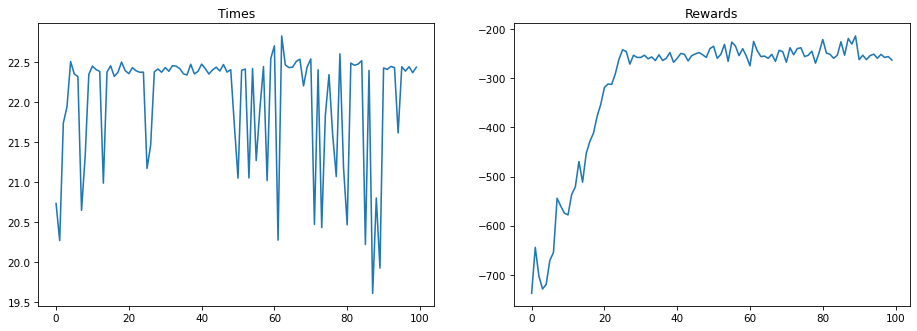

In [24]:
tot_epochs_train=1000 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=10)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

In [ ]:
mEnv.save(path=dir_DQNTaxi, name="values") # optional, to the agent trained

In [25]:
mEnv.test(20) # test the agent

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 20
Action: down
Reward: -20


##Sarsa CarPole

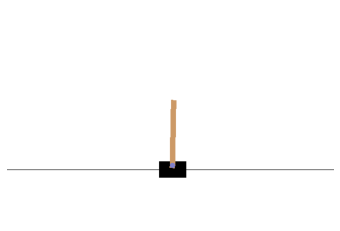

In [ ]:
# Current enviroment
env = gym.make("CartPole-v1")
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'));

###Class

In [ ]:
class CarpoleEnv(ObservationWrapper):
  def __init__(self, env, bins, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, low, high):
    super().__init__(env)

    # Number of bins per feature
    self._bins = bins

    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

    # Discretization of the observation space
    self.observation_space = Discrete(np.prod(self._bins))

    # Object to bin continuous data into intervals
    self._bins_discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    self._bins_discretizer.fit([low, high])

    # Q table and H table
    self._Q = np.zeros(shape=(self.observation_space.n, self.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))
  
  # Return the index of the table that correspond to this observation
  def fromObsToNum(self, observation):
    return sum([observation[-(i+1)] if i == 0 else reduce(lambda x, y: x*y, self._bins[-i:]) * observation[-(i+1)] for i in reversed(range(len(self._bins))) ])

  # Discretize the observation into the bins
  def discretizer(self, car_position, car_velocity, pole_angle, pole_velocity):
    return tuple(map(int, self._bins_discretizer.transform([[car_position, car_velocity, pole_angle, pole_velocity]])[0] ))

  # Overriding the method observation in order to return the discretized observation
  def observation(self, observation):
    return self.fromObsToNum(self.discretizer(*observation))

  # return the next action to do based on the current observation
  def policy(self, current_observation):
    return np.argmax(self._Q[current_observation])
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())

  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.action_space.sample()
        
        # Perform action
        next_observation, reward, done, _info = self.step(action)
        next_action = self.policy(next_observation)

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * self._Q[next_observation, next_action] *\
            (1-int(done)) - self._Q[current_observation, action]
        intent_update = np.zeros(self._Q.shape)

        intent_update[current_observation, action] += 1
        expected_intent = intent_update + self._γ * self._H[next_observation, next_action] *\
            (1-int(done)) - self._H[current_observation, action]
        
        # update Q and H
        self._Q[current_observation, action] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
            self._α * expected_intent

        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))
        start = time.time()
        
      self.close()
    self.close()
  
  # Function used to test the trained agent
  def test(self, filename, max = 20, pltF = False):
    # create a new File video
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=30) as video:
      # Restart the enviroment
      current_observation = self.reset()
      # add the current state of the enviroment
      video.append_data(self.render(mode='rgb_array'))
      # init data for the loop
      done = False
      limit = 0
      while not done and limit < max:
        # takes an action based on the policy
        action = self.policy(current_observation)
        # perform action
        next_observation, reward, done, _info = self.step(action)

        current_observation = next_observation
        # add the current state of the enviroment
        video.append_data(self.render(mode='rgb_array'))
        limit += 1
    self.close()
    return embed_mp4(filename)

###Test

learning rate α = 0.1 and discount factor γ = 1

Episode terminates when the length of the episode reaches
200 timestep

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1
throughout the first 500 episodes

In [ ]:
env = gym.make('CartPole-v1') # enviroment

bins=np.array([3, 3, 6, 3]) # bins to subdivide the observation state [car_position, car_velocity, pole_angle, pole_velocity]

α = 0.1 # learning rate
γ = 1.0 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 500 # number of epochs decay

low = np.array([-2.4, -2.5, -np.radians(12), -1]) # Observation space min value
high = np.array([2.4, 2.5, np.radians(12), 1]) # Observation space max value

mEnv = CarpoleEnv(env, bins, α, γ, ε_init_value, ε_final_value, ε_tot_epochs, low, high) # create the enviroment

In [ ]:
mEnv.load(path=dir_SarsaCarPole, name="values") # optional, to load a pretrained agent

Episode 10, reward: 22.600000,  time: 0.086958 s
Episode 20, reward: 17.000000,  time: 0.051484 s
Episode 30, reward: 21.900000,  time: 0.071201 s
Episode 40, reward: 23.400000,  time: 0.075549 s
Episode 50, reward: 16.100000,  time: 0.054746 s
Episode 60, reward: 27.000000,  time: 0.102792 s
Episode 70, reward: 24.800000,  time: 0.085964 s
Episode 80, reward: 26.000000,  time: 0.082895 s
Episode 90, reward: 21.900000,  time: 0.074217 s
Episode 100, reward: 30.100000,  time: 0.096831 s
Episode 110, reward: 26.600000,  time: 0.080990 s
Episode 120, reward: 19.000000,  time: 0.070168 s
Episode 130, reward: 32.900000,  time: 0.120488 s
Episode 140, reward: 37.100000,  time: 0.126034 s
Episode 150, reward: 21.900000,  time: 0.078446 s
Episode 160, reward: 27.300000,  time: 0.085962 s
Episode 170, reward: 34.500000,  time: 0.105840 s
Episode 180, reward: 38.000000,  time: 0.129103 s
Episode 190, reward: 43.700000,  time: 0.147281 s
Episode 200, reward: 42.100000,  time: 0.141261 s
Episode 2

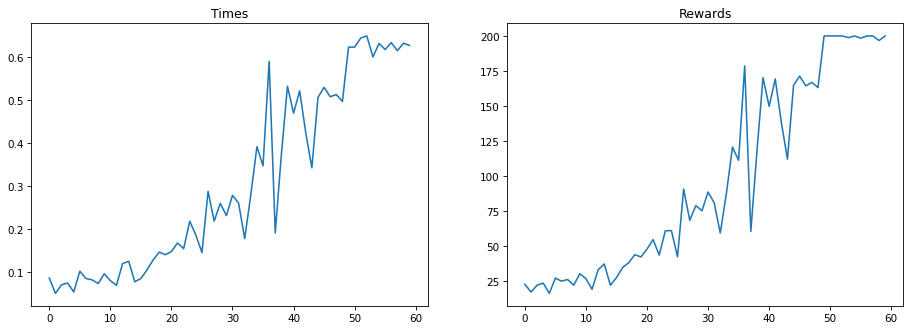

In [ ]:
tot_epochs_train= 600 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=10)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

In [ ]:
mEnv.save(path=dir_SarsaCarPole, name="values") # optional, to the agent trained

In [ ]:
mEnv.test("QCarPole", max = 200, pltF = False) # test the agent

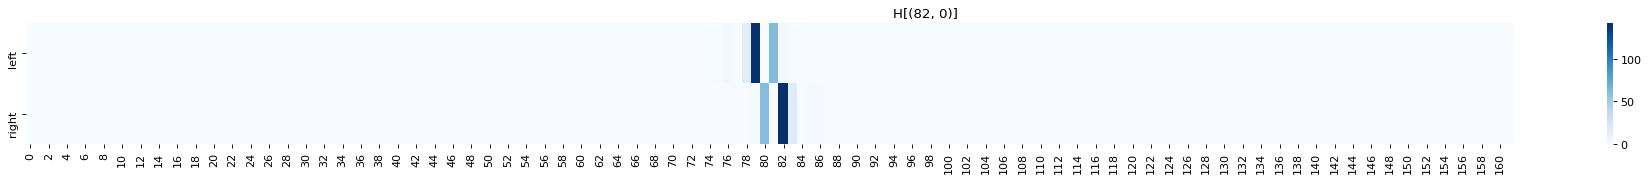

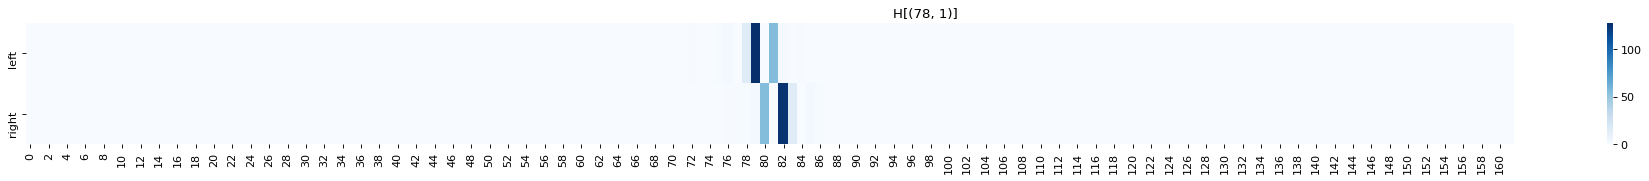

In [ ]:
fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H[(82, 0)]")
sns.heatmap(np.transpose(mEnv._H[(82, 0)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

fig = plt.figure(figsize=(30, 2), dpi=80, )
fig.suptitle("H[(78, 1)]")
sns.heatmap(np.transpose(mEnv._H[(78, 1)]), cmap='Blues', linewidths=.0, xticklabels=2, yticklabels=['left', 'right'], square=False)#True)
plt.show()

##Sarsa Taxi

In [ ]:
# Current enviroment
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



###Class

In [ ]:
class TaxiEnv(ObservationWrapper):
  def __init__(self, env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs):
    super().__init__(env)

    self._α = α # Learning rate
    self._γ = γ # Discount factor

    # Exploration
    self._ε_init_value = ε_init_value
    self._ε_final_value = ε_final_value
    self._ε_tot_epochs = ε_tot_epochs

    # Q table and H table
    self._Q = np.zeros((env.observation_space.n, env.action_space.n))
    self._H = defaultdict(lambda: np.zeros(shape=self._Q.shape))
    
    # Arrays to save execution times and rewards during training
    self.times = []
    self.rewards = []

  # Overriding the method observation
  def observation(self, observation):
    return observation

  # return the next action to do based on the current observation
  def policy(self, state_action):
    return np.argmax(self._Q[state_action])
  
  # Return the value of the exploration time based on the current epoch in a linear way
  def explorationValue(self, epoch):
    epochs_progress = epoch/self._ε_tot_epochs
    if epochs_progress > 1:
      return self._ε_final_value
    return self._ε_init_value + epochs_progress * (self._ε_final_value - self._ε_init_value)

  # return the time between 2 intervals
  def elapsedTime(self, start):
    done = time.time()
    elapsed = done - start
    self.times.append(elapsed)
    return elapsed
  
  # Saves the Q and H table
  def save(self, path="./", name='values'):
    np.save(path+name+'_Q', self._Q, allow_pickle=True)
    np.savez(path+name+'_H', dict(self._H), allow_pickle=True)

  # Load the Q and H table
  def load(self, path="./", name='values'):
    self._Q[:] = np.load(path+name+'_Q.npy', allow_pickle=True)
    with np.load(path+name+'_H.npz', allow_pickle = True) as data:
            self._H.update(data['arr_0'].item())
    
  def train(self, tot_epochs_train, max_epoch_step, print_info=False, print_info_episodes=100):
    # inizialize data for time execution ad rewards
    start = time.time()
    epoch_reward = 0

    # starting main loop for training
    for epoch in range(1, tot_epochs_train+1):
      # inizialize data
      step = 0 # number of actions done in this epoch
      done = False # bool to check termination
      current_observation = self.reset() # starting the enviroment
      
      # do actions until the agent terminate or has done enough steps
      while not done and step < max_epoch_step:
        # the agent pick an action
        if np.random.random_sample() > self.explorationValue(epoch):
          # random action
          action = self.policy(current_observation)
        else:
          # action based on the policy
          action = self.action_space.sample()

        # Perform action
        next_observation, reward, done, _info = self.step(action)
        next_action = self.policy(next_observation)
        argmax_a = np.argmax(self._Q[next_observation])

        # Compute data to evaluate expected_reward and intent_update used to update Q and H
        expected_reward = reward + self._γ * self._Q[next_observation, next_action] *\
            (1-int(done)) - self._Q[current_observation, action]
        intent_update = np.zeros(self._Q.shape)
        intent_update[current_observation, action] += 1
        
        expected_intent = intent_update + self._γ * self._H[next_observation, next_action] *\
         (1-int(done)) - self._H[current_observation, action]
        
        # update Q and H
        self._Q[current_observation, action] += self._α * expected_reward
        self._H[current_observation, action] = self._H[current_observation, action] +\
         self._α * expected_intent
        
        # update data for the loop
        current_observation = next_observation
        step += 1
        epoch_reward += reward
      
      # Print informations for the training
      if print_info and (epoch) % print_info_episodes == 0:
        avgReward = epoch_reward/print_info_episodes
        epoch_reward = 0
        self.rewards.append(avgReward)
        print("Episode %d, reward: %f,  time: %f s" %(epoch, avgReward, self.elapsedTime(start)))
        start = time.time()
      
      self.close()
    self.close()

  # Function used to test the trained agent
  def test(self, max=50, pltF = False):
    # create a new Buffer
    frames = []
    # Restart the enviroment
    current_observation = self.reset()
    done = False
    limit = 0
    actions = ["down", "up", "right", "left", "pickup passenger", "drop off passenger"]
    sum_reward = 0

    # init data for the loop
    while not done and limit < max:
      # takes an action based on the policy
      action = self.policy(current_observation)
      # perform action
      next_observation, reward, done, _info = self.step(action)

      if pltF:
        print("step: ", limit)
        print("current_observation: ", current_observation)
        print("action: ", action)
        plt.plot(mEnv._H[current_observation, action])
        plt.legend(actions)
        plt.show()
        self.render()

      current_observation = next_observation
      limit += 1
      sum_reward += reward

      # add the current state of the enviroment
      frames.append({
        'frame': env.render(mode='ansi'),
        'observation': next_observation,
        'action': actions[action],
        'reward': sum_reward
        })
    self.close()
    def print_frames(frames):
      for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(.5)
    if not pltF:
      return print_frames(frames)

###Test

learning rate α = 0.4 and discount factor γ = 0.9

Episode terminates when the length of the episode reaches
200 timestep

We initially set exploration probability ε = 1 which is linearly decreased to ε = 0.1
throughout the first 250 episodes

In [ ]:
env = gym.make('Taxi-v3') # enviroment

α = 0.4 # learning rate
γ = 0.9 # discount factor

ε_init_value = 1 # exploration probability
ε_final_value = 0.1 # final exploration value
ε_tot_epochs = 250 # number of epochs decay

mEnv = TaxiEnv(env, α, γ, ε_init_value, ε_final_value, ε_tot_epochs)

In [ ]:
mEnv.load(path=dir_SarsaTaxi, name="values") # optional, to load a pretrained agent

Episode 100, reward: -643.090000,  time: 1.521456 s
Episode 200, reward: -274.150000,  time: 0.902596 s
Episode 300, reward: -53.380000,  time: 0.363129 s
Episode 400, reward: -19.200000,  time: 0.226957 s
Episode 500, reward: -7.250000,  time: 0.158202 s
Episode 600, reward: -2.750000,  time: 0.130245 s
Episode 700, reward: 0.640000,  time: 0.128343 s
Episode 800, reward: 2.420000,  time: 0.109461 s
Episode 900, reward: 1.330000,  time: 0.107612 s
Episode 1000, reward: 1.350000,  time: 0.105853 s
Episode 1100, reward: 1.190000,  time: 0.105934 s
Episode 1200, reward: 2.050000,  time: 0.111154 s
Episode 1300, reward: 2.120000,  time: 0.107092 s
Episode 1400, reward: 1.560000,  time: 0.104080 s
Episode 1500, reward: 3.090000,  time: 0.100994 s
Episode 1600, reward: 1.340000,  time: 0.120232 s
Episode 1700, reward: 2.050000,  time: 0.101943 s
Episode 1800, reward: 2.570000,  time: 0.110138 s
Episode 1900, reward: 1.450000,  time: 0.099270 s
Episode 2000, reward: 3.540000,  time: 0.100156

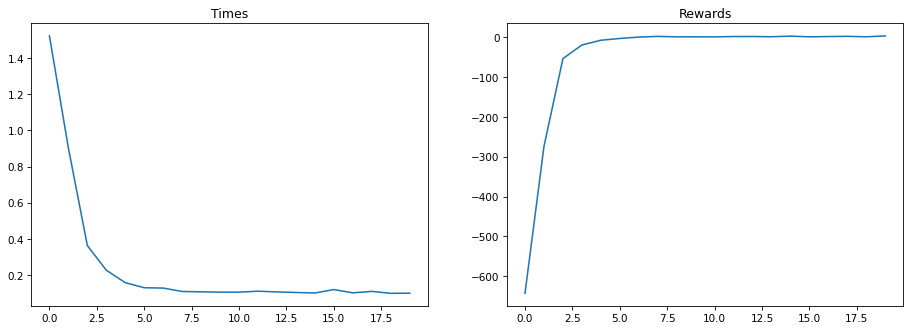

In [ ]:
tot_epochs_train=2000 # number fo epochs
max_epoch_step=200 # number of steps to terminate an epoch

# train the agent
mEnv.train(tot_epochs_train, max_epoch_step, print_info=True, print_info_episodes=100)

# plot time exection and rewards over time
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=75)
ax[0].title.set_text("Times")
ax[0].plot(mEnv.times)
ax[1].title.set_text("Rewards")
ax[1].plot(mEnv.rewards)
plt.show()

In [ ]:
mEnv.save(path=dir_SarsaTaxi, name="values") # optional, to the agent trained

step:  0
current_observation:  141
action:  0


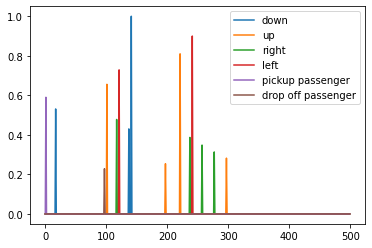

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step:  1
current_observation:  241
action:  3


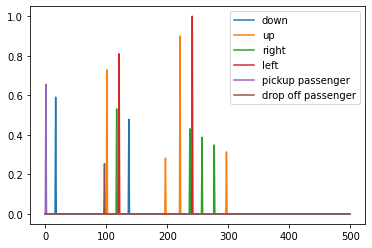

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
step:  2
current_observation:  221
action:  1


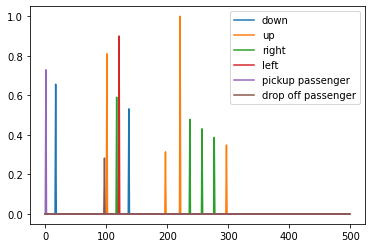

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  3
current_observation:  121
action:  3


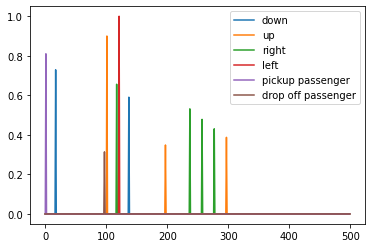

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
step:  4
current_observation:  101
action:  1


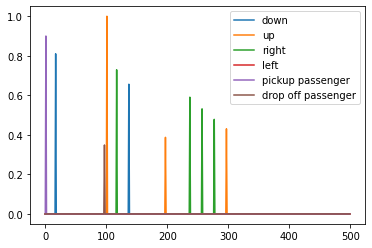

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  5
current_observation:  1
action:  4


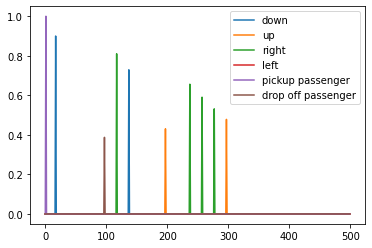

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
step:  6
current_observation:  17
action:  0


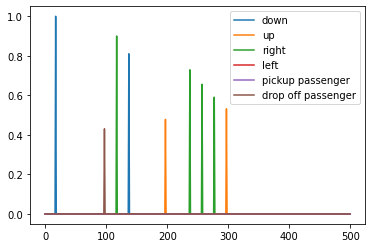

+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step:  7
current_observation:  117
action:  2


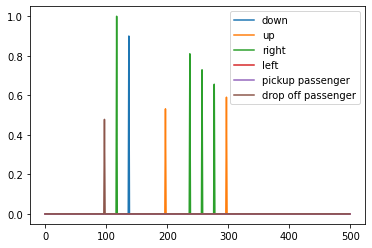

+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
step:  8
current_observation:  137
action:  0


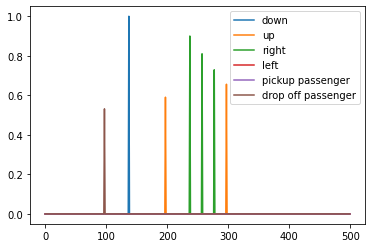

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
step:  9
current_observation:  237
action:  2


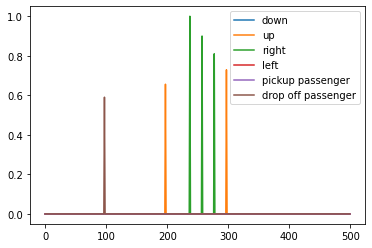

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
step:  10
current_observation:  257
action:  2


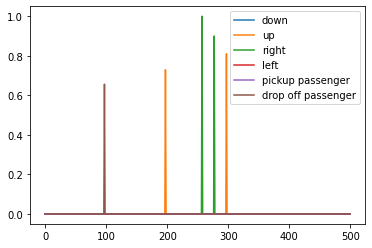

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
step:  11
current_observation:  277
action:  2


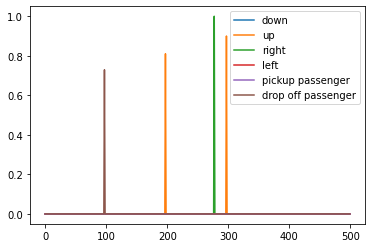

+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (East)
step:  12
current_observation:  297
action:  1


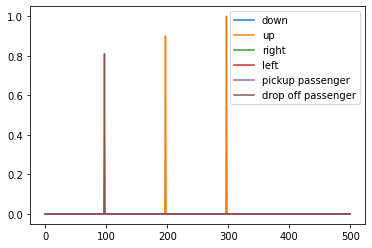

+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  13
current_observation:  197
action:  1


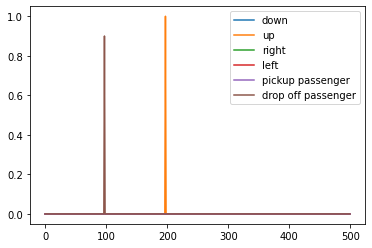

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
step:  14
current_observation:  97
action:  5


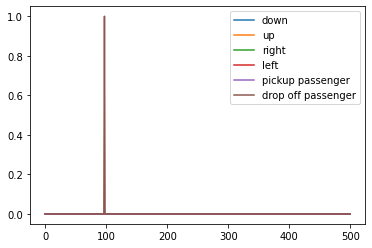

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [ ]:
mEnv.test(max = 20, pltF = True) # test the agent